# Exploratory Data Analysis on Twitter Data

## Introduction

With the effects of climate change and global warming becoming more alarming, where the Earth's temperature rising at record rate, rainfall patterns are changing, and sea levels are rising, people are becoming more aware to this problem and starting to recognise this existential emergency. 

Greta Thunberg is one of those who took action in combating climate change. Thunberg is a Swedish teenager who started a school strike alone in front of  the Swedish parliament, calling for stronger action on climate change. This climate-activist was named Person of the Year 2019 by Time Magazine. She is responsible for inspiring a series of international strikes and protests to demand action be taken to address climate change. Many argued that the climate strikes are influential in the recent political advancement in Western countries.

<img src="times2019.jpg" width = 300>
Source: time.com

This project is an Exploratory Data Anlysis (EDA) for a dataset of Twitter tweets containing the hashtag **#ClimateStrike**, refering to the movement that Greata Thunberg has started. This hashtag is about raising awareness about climate change and urging people to take actions against this impending problem. We chose a sample of tweets containing the hashtag **#ClimateStrike** during the week where the Australian Bush Fires were worsening. 

The following analysis aims at investiagating the public's reaction towards this climate activism movement. More precisly we are going to provide an insight on the demographics of these users, explore the content of their public speech on the social media platform Twitter, identify potential opinion leaders on this subject and finally, we are going to explore the sentiments of such tweets.


## Objectives
In this notebook, we are focusing on the following objectives:

1. Analyzing the demographic and user attributes of those Twitter users using this hashtag. Especially we are interested the geographical locations of these Twitter users as well as the language that the tweets are in.
2. Analyzing the words used in these tweets and how similar they are by consine similartiy and word clouds.
3. Analysing the sentiments of tweets containing the hashtag. Are they always negative?

## 1. Dataset

In [1]:
#Importing required modules
from afinn import Afinn
import collections
from datetime import datetime
from gensim.models import Word2Vec
import geograpy3
from helper import *
import json
import nltk
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
import pycountry
from pycountry_convert import country_name_to_country_alpha3
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import string
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import seaborn as sns

#Set styles
plt.style.use('seaborn')
sns.set_style("whitegrid")
sns.axes_style("darkgrid") 

%matplotlib inline

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/icy_lmt/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/icy_lmt/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/icy_lmt/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /Users/icy_lmt/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/icy_lmt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/icy_lmt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### 1.1 Capturing Twitter Data

After registering and created API keys and access tokens from Twitter(Consumer Key, Consumer Secret, Access Token and Access Token Secret) we are able to scrap tweets from the Twitter API using the Python library Twython. The complete procedure for tweets-scrapping can be found in the separate notebook: tweets_scrapping.ipynb

There are in total 10,095 tweets in this dataset containing the hashtag #ClimateStrike. The tweets were scrapped through the use of the Twitter API during the time period of 10th to 16th January 2020, amidst the Australian Bush Fires time period.

#### 1.2 Data Loading

In [2]:
tweets_df = pd.read_json("tweets_new.json")
col_names = tweets_df.columns.tolist()

print("Column names:")
print(col_names)

print("\nSample size:")
print(len(tweets_df))

print("\nSample data:")
tweets_df.head(6)

Column names:
['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang', 'retweeted_status', 'extended_entities', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status']

Sample size:
10095

Sample data:


created_at                   id               id_str  \
0 2020-01-14 15:19:17+00:00  1217103901532524544  1217103901532524544   
1 2020-01-14 12:22:00+00:00  1217059287517794304  1217059287517794304   
2 2020-01-14 21:54:37+00:00  1217203392071847945  1217203392071847936   
3 2020-01-15 10:22:20+00:00  1217391557705379840  1217391557705379840   
4 2020-01-15 10:21:46+00:00  1217391417712091136  1217391417712091136   
5 2020-01-15 10:21:26+00:00  1217391331569520640  1217391331569520640   

                                                text  truncated  \
0  "I could not hold my tears watching this...Is ...       True   
1  "We're tired. We're done. It's time for change...       True   
2  America’s youth climate movements are planning...       True   
3  RT @fff_Sydney: Climate Strike Sydney, Austral...      False   
4  RT @arikring: @ECOWARRIORSS @MsFowlersays @Chr...      False   
5  RT @realJohnACastro: My #GreenEnergy Jobs Plan...      False   

                                            entities  \
0  {'hashtags': [], 'symbols': [], 'user_mentions...   
1  {'hashtags': [], 'symbols': [], 'user_mentions...   
2  {'hashtags': [{'text': 'EarthDay', 'indices': ...   
3  {'hashtags': [], 'symbols': [], 'user_mentions...   
4  {'hashtags': [], 'symbols': [], 'user_mentions...   
5  {'hashtags': [{'text': 'GreenEnergy', 'indices...   

                                            metadata  \
0  {'result_type': 'popular', 'iso_language_code'...   
1  {'result_type': 'popular', 'iso_language_code'...   
2  {'result_type': 'popular', 'iso_language_code'...   
3  {'iso_language_code': 'en', 'result_type': 're...   
4  {'iso_language_code': 'en', 'result_type': 're...   
5  {'iso_language_code': 'en', 'result_type': 're...   

                                              source  in_reply_to_status_id  \
0  <a href="https://buffer.com" rel="nofollow">Bu...                    NaN   
1  <a href="https://buffer.com" rel="nofollow">Bu...                    NaN   
2  <a href="https://studio.twitter.com" rel="nofo...                    NaN   
3  <a href="https://mobile.twitter.com" rel="nofo...                    NaN   
4  <a href="http://twitter.com/download/android" ...                    NaN   
5  <a href="https://mobile.twitter.com" rel="nofo...                    NaN   

   in_reply_to_status_id_str  ...  favorite_count  favorited retweeted  \
0                        NaN  ...             425      False     False   
1                        NaN  ...             114      False     False   
2                        NaN  ...              29      False     False   
3                        NaN  ...               0      False     False   
4                        NaN  ...               0      False     False   
5                        NaN  ...               0      False     False   

  possibly_sensitive lang                                   retweeted_status  \
0                0.0   en                                                NaN   
1                0.0   en                                                NaN   
2                0.0   en                                                NaN   
3                NaN   en  {'created_at': 'Fri Jan 10 06:35:01 +0000 2020...   
4                NaN   en  {'created_at': 'Tue Jan 14 20:09:21 +0000 2020...   
5                NaN   en  {'created_at': 'Thu Jan 09 03:42:22 +0000 2020...   

  extended_entities  quoted_status_id  quoted_status_id_str  quoted_status  
0               NaN               NaN                   NaN            NaN  
1               NaN               NaN                   NaN            NaN  
2               NaN               NaN                   NaN            NaN  
3               NaN               NaN                   NaN            NaN  
4               NaN               NaN                   NaN            NaN  
5               NaN               NaN                   NaN            NaN  

[6 rows x 30 columns]

#### 1.3 Data Cleansing and Manipulation

First we extract data of interest from column where there are dictionaries containing such information.

In [3]:
hashtag_meta = []
user_mention_meta = []
tweet_location = []
tweet_coordinates = []

for i in range(len(tweets_df)):
    if tweets_df['place'][i] is not None:
        tweet_location.append(tweets_df['place'][i]['full_name'])
        tweet_coordinates.append(tweets_df['place'][i]['bounding_box']['coordinates'])
    else:
        tweet_location.append(None)
        tweet_coordinates.append(None)
    
    hashtags = []
    for j in tweets_df['entities'][i]['hashtags']:
        hashtags.append(j['text'])
    if len(hashtags) == 0:
        hashtags = None
    hashtag_meta.append(hashtags)
    
    user_mention = []
    for j in tweets_df['entities'][i]['user_mentions']:
        user_mention.append(j['id'])
    if len(user_mention) == 0:
        user_mention = None
    user_mention_meta.append(user_mention)

tweets_df['Results_type'] = tweets_df['metadata'].apply(lambda x: x['result_type'] )
tweets_df['User_name'] = tweets_df['user'].apply(lambda x: x['name'] )
tweets_df['User_ID'] = tweets_df['user'].apply(lambda x: x['id'] )
tweets_df['User_tweets_count'] = tweets_df['user'].apply(lambda x: x['statuses_count'] )
tweets_df['User_follwers_count'] = tweets_df['user'].apply(lambda x: x['followers_count'] )
tweets_df['User_favourites_count'] = tweets_df['user'].apply(lambda x: x['favourites_count'] )
tweets_df['User_number_of_following'] = tweets_df['user'].apply(lambda x: x['friends_count'] )
tweets_df['Verified_user'] = tweets_df['user'].apply(lambda x: x['verified'] )
tweets_df['User_geolocation'] = tweets_df['user'].apply(lambda x: x['location'] )
tweets_df['User_language'] = tweets_df['user'].apply(lambda x: x['lang'] )
tweets_df['Other_hashtags_used'] = hashtag_meta 
tweets_df['Other_user_mentioned'] = user_mention_meta
tweets_df['Tweet_location_name'] = tweet_location
tweets_df['Tweet_location_coordinates'] = tweet_coordinates
tweets_df['Retweet'] = tweets_df['retweeted_status'].apply(lambda x: 1 if type(x) == dict else 0 )

#Dropping unwanted columns
tweets_df = tweets_df.drop(['id_str', 'contributors', 'favorited', 'retweeted',
                                'extended_entities', 'quoted_status_id_str', 'entities',
                            'metadata', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 'user',
                           'geo', 'coordinates', 'possibly_sensitive', 'place'], axis = 1)


In [4]:
#Renaming the columns
tweets_df.columns = ['Tweet_posted_time', 'Tweet_ID', 'Tweet_body', 'Tweet_truncated', 'Tweet_Source',
                     'Tweet_InReplyToStatusID','Tweet_InReplyToUserID', 'Tweet_InReplyToScreenName', 'Tweet_Quote',
                    'Retweet_count', 'Favourite_count', 'Tweet_language', 'Retweeted_status', 'Quoted_status_ID',
                    'Quoted_status', 'Results_type', 'User_name', 'User_ID', 'User_tweets_count','User_follwers_count',
                    'User_favourites_count', 'User_number_of_following', 'Verified_user','User_geolocation',
                    'User_language','Other_hashtags_used', 'Other_user_mentioned', 'Tweet_location_name',
                    'Tweet_location_coordinates', 'Retweet']

#### 1.4 Data Dictionary

- Tweet_posted_time: UTC time when the tweet was posted
- Tweet_ID: Unique ID of the tweet
- Tweet_body: Body of text of the tweet
- Tweet_truncated: Boolean expression indicating whether the text of the tweet was truncated
- Tweet_Source: source of the tweet
- Other_hashtags_used: Other hashtags present in the tweet
- Other_user_mentioned: Other twitter user mentioned in the tweet
- Tweet_location_name: Location of the tweet
- Tweet_location_coordinates: Coordinates of the location of the tweet
- Tweet_language: the language that the tweet is in
- Tweet_InReplyToStatusID: The tweet ID that the tweet is a reply to
- Tweet_InReplyToUserID: The user ID that the tweet is replying to
- Tweet_InReplyToScreenName: Name of the user that the tweet is replying to
- Tweet_Quote: Whether the tweet is a quoted tweet from others
- Retweet_count: Number of retweets of the tweet
- Favourite_count: Number of favourites that the tweet has received
- Retweeted_status: The body of the retweeted tweet if the tweet is one
- Quoted_status_ID: Unique ID of the quoted tweet if the tweet is one
- Quoted_status: The body of the quoted tweet if the tweet is one
- Results_type: Whether the tweet is recent or popular
- User_name: User name
- User_ID: Unique user ID
- User_tweets_count: Number of tweets that the user has made 
- User_follwers_count: Number of followers that the user has
- User_favourites_count: Number of favourites that the user has received
- User_number_of_following: Number of account that the user is following
- Verified_user: Boolean expression indicating whether the user is verified or not
- User_geolocation: Location of the user indicated in his/her profile
- User_language: Language of the user indicated in his/her profile
- Retweet: Whether this tweet is a retweet

#### 1.5 Data Validation

Since there are several missing values and "nan" values in the raw dataset, we would like to perform data validation in order to produce a complete set of data for analysis purposes later on.

In [5]:
null = len(tweets_df) - tweets_df.isnull().sum()
print(null)

Tweet_posted_time             10095
Tweet_ID                      10095
Tweet_body                    10095
Tweet_truncated               10095
Tweet_Source                  10095
Tweet_InReplyToStatusID         182
Tweet_InReplyToUserID           199
Tweet_InReplyToScreenName       199
Tweet_Quote                   10095
Retweet_count                 10095
Favourite_count               10095
Tweet_language                10095
Retweeted_status               9110
Quoted_status_ID                701
Quoted_status                   259
Results_type                  10095
User_name                     10095
User_ID                       10095
User_tweets_count             10095
User_follwers_count           10095
User_favourites_count         10095
User_number_of_following      10095
Verified_user                 10095
User_geolocation              10095
User_language                     0
Other_hashtags_used            7909
Other_user_mentioned           9425
Tweet_location_name         

As the column User_language is completely empty, we remove User_language.

In [6]:
tweets_df = tweets_df.drop(['User_language'], axis=1)

In order to deal with the empty strings in the column User_geolocation, we clean the column by replacing them with Python None values.

In [7]:
for i in range(len(tweets_df['User_geolocation'])):
    if tweets_df['User_geolocation'][i] == '':
        tweets_df['User_geolocation'][i] = None

The following is our dataset which we will work on for our exploratory data analysis. We have set the threshold at 6000, which is approximately 2/3 of the total number of datapoints. As a result, we will not be conducting analysis on the columns Tweet_location_name, Tweet_location_coordinates, Tweet_InReplyToUserID, Tweet_InReplyToStatusID, Tweet_InReplyToScreenName, Quoted_status_ID, Quoted_status. 

The missing data are:
Tweet_posted_time             10095
Tweet_ID                      10095
Tweet_body                    10095
Tweet_truncated               10095
Tweet_Source                  10095
Tweet_InReplyToStatusID         182
Tweet_InReplyToUserID           199
Tweet_InReplyToScreenName       199
Tweet_Quote                   10095
Retweet_count                 10095
Favourite_count               10095
Tweet_language                10095
Retweeted_status               9110
Quoted_status_ID                701
Quoted_status                   259
Results_type                  10095
User_name                     10095
User_ID                       10095
User_tweets_count             10095
User_follwers_count           10095
User_favourites_count         10095
User_number_of_following      10095
Verified_user                 10095
User_geolocation               6813
Other_hashtags_used            7909
Other_user_mentioned           9425
Tweet_location_name              39
Tweet_

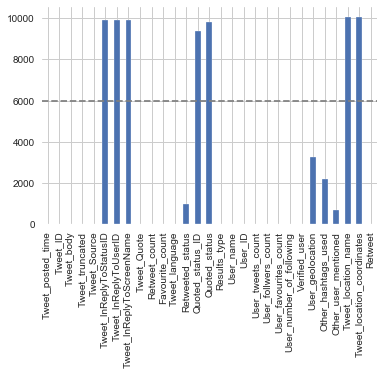

In [8]:
#Count number of non-nulls per column
null = len(tweets_df) - tweets_df.isnull().sum()

print("The missing data are:")
print(null)

print("\nVisualizing:")
fig, ax = plt.subplots(figsize = (6, 4))
tweets_df.isnull().sum().plot(kind = 'bar')
plt.axhline(y = 6000, color = 'grey', linestyle = '--')
plt.show()

In [9]:
#Remove columns that are above the threshold
tweets_df = tweets_df.drop(['Tweet_location_name', 'Tweet_location_coordinates',
                            'Tweet_InReplyToUserID', 'Tweet_InReplyToStatusID', 'Tweet_InReplyToScreenName',
                            'Quoted_status_ID', 'Quoted_status'], axis = 1)

## 2. Data Analysis

#### 2.1 Preliminary analysis on the tweets

First we analyse some basic facts about the data, namely the number of tweets published per day. The bar graph below shows that the most popular day within this period was 10th January 2020 with more than 4,000 tweets using **#ClimateStrike**. It is not surprising that the number of tweets with such hashtag spiked on that day as on that day the Australia Bush Fire news made headlines, announcing that the government officials in Australian urged 250,000 people to evacuate their homes on that day because of weather conditions that may worsen the bush fires.

<img src="cnbc.png" width=800>
Source: cnbc.com

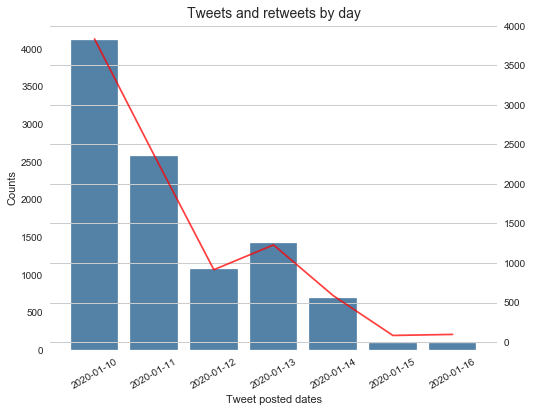

In [10]:
tweets_df['Tweet_posted_date'] = [datetime.strptime(str(date).split()[0], '%Y-%m-%d')
                                  for date in tweets_df['Tweet_posted_time']]
df = pd.DataFrame([tweets_df['Tweet_posted_date']]).T
df2 = tweets_df.groupby('Tweet_posted_date')[["Retweet"]].sum()

fig, ax = plt.subplots(figsize = (8, 6))
g = sns.countplot(x = "Tweet_posted_date", data = df, color = "steelblue")
g.set_xticklabels(['2020-01-10','2020-01-11','2020-01-12','2020-01-13','2020-01-14','2020-01-15','2020-01-16'])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set(xlabel = 'Tweet posted dates', ylabel = 'Counts')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), df2, alpha = .75, color = 'r')
ax.grid(False)
plt.title("Tweets and retweets by day", fontsize = 14)
plt.show()

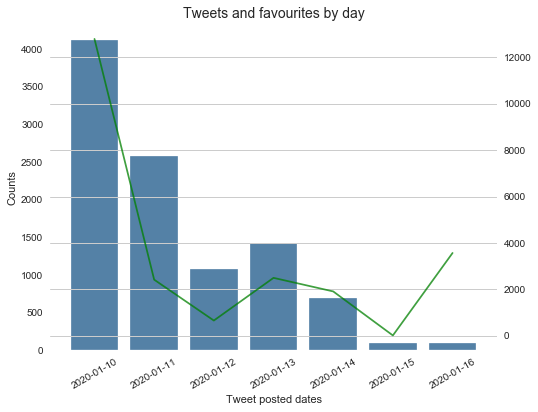

In [11]:
df3 = tweets_df.groupby('Tweet_posted_date')[["Favourite_count"]].sum()
fig, ax = plt.subplots(figsize = (8, 6))
g = sns.countplot(x = "Tweet_posted_date", data = df, color = "steelblue")
g.set_xticklabels(['2020-01-10','2020-01-11','2020-01-12','2020-01-13','2020-01-14','2020-01-15','2020-01-16'])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set(xlabel = 'Tweet posted dates', ylabel = 'Counts')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), df3, alpha = .75, color = 'green')
ax.grid(False)
plt.title("Tweets and favourites by day", fontsize = 14)
plt.show()

As we can see from the above, the amount of retweets daily are relatively proportional to the total amount of tweets per day. They are generally going in the same direction per day. However, for the amount of faviourites of the tweets per day, they are not quite so. For example on 16th January 2020, the number of tweets is only 99 that day but the aggregated number of favourites is 3568. This means that on 16th January 2020, there might be some very influential tweets that garnered a lot of reactions of the audience.

#### 2.2 Other hashtags used

In order to get a better idea on what the tweets are about, one of the more direct way to do so is to investigate the other hashtags used in addition to **#ClimateStrike**. After cleaning and restructuring the data, we rank the top 50 most frequently used hashtags amongst these tweets.

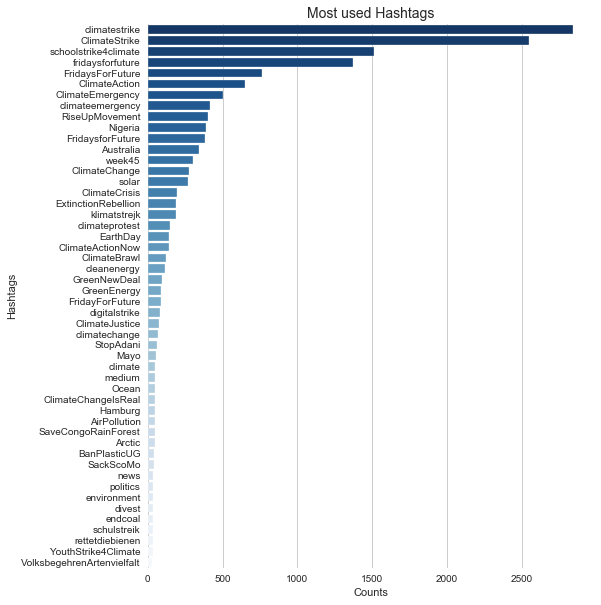

In [12]:
df_tags = []
for i in range(len(tweets_df['Other_hashtags_used'])):
    if tweets_df['Other_hashtags_used'][i] != None:
        for j in tweets_df['Other_hashtags_used'][i]:
            df_tags.append(j)
df_tags = dict((x, df_tags.count(x)) for x in set(df_tags))
df_tags = pd.DataFrame(df_tags, index=[0]).T
df_tags = df_tags.reset_index()
df_tags.columns = ["Hashtags", "Counts"]
df_tags.sort_values(ascending = False, by = 'Counts', inplace = True)
df_tags_1 = df_tags.iloc[:50,:]

fig, ax = plt.subplots(figsize = (8, 10))
g = sns.barplot(x = "Counts", y = "Hashtags", data = df_tags_1, palette = "Blues_r")
plt.title("Most used Hashtags", fontsize = 14)
plt.show()

We can see from the above bar chart that the most frequently used hashtags (besides **#climatestrike**) are: **#schoolstrike4climate**, **#Fridaysforfuture**, **#ClimateAction**, **#ClimateEmergency** ... these are the hashtags that are alias of **#climatestrike**. Interestingly, the hashtags **#Nigeria** and **#Australia** are amongst the top 10 unique hashtags mentioned in addition the our hashtag. This suggests that the Twitter users using these hashtags may be a part of a global community, or that they are intending to get their message through Twitter to a global audience.

Other hashtags that indicate the content of their tweets are **#sackSoMo** and **#StopAdani**. They refer to the protests in Australia about sacking the current Australian Prime Minister Scott Morrison based on his poor record on climate action and handling of the ongoing bushfire crisis; and also, the movement about stopping the conglomerate Adani to dig one of the biggest coal mines in the world in Queensland's Galilee Basin. Surprisingly, **#AustraliaFires** is not used that often during this period. Another frequently used hashtag is **#CongoRainforest**, which refers to conservation of the Congo rainforests from deforestation in Africa.

#### 2.3 Tweet Language

Another feature that characterises the Twitter user demographic of interest is the languages that the Tweets were posted in. This is important as it gives us an idea of the demographic of people who are interested in Climate Activism.

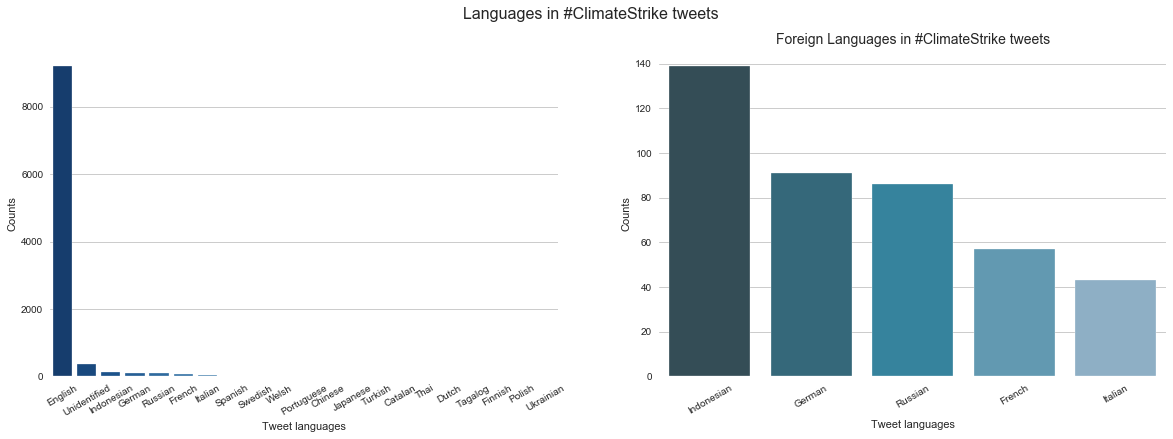

In [13]:
counts = tweets_df['Tweet_language'].value_counts()
df_counts = pd.DataFrame(counts)
df_counts = df_counts.reset_index()
df_counts.columns = ["Tweet languages", "Counts"]
df_counts["Tweet languages"] = ["English", "Unidentified", "Indonesian", "German", "Russian", "French", 
                               "Italian", "Spanish", "Swedish", "Welsh", "Portuguese", "Chinese", "Japanese",
                               "Turkish", "Catalan", "Thai", "Dutch", "Tagalog", "Finnish", "Polish", "Ukrainian"]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
g = sns.barplot(x = 'Tweet languages', y = "Counts", data = df_counts, ax = ax[0], palette = "Blues_r")
g.set_xticklabels(g.get_xticklabels(), rotation=30)

df_counts = df_counts.iloc[1:7,:]
f = sns.barplot(x = 'Tweet languages', y = "Counts", data = df_counts.iloc[1:10,:],  ax = ax[1], palette = "PuBuGn_d")
f.set_xticklabels(f.get_xticklabels(), rotation=30, fontsize = 10)
plt.suptitle("Languages in #ClimateStrike tweets", fontsize = 16)
plt.title("Foreign Languages in #ClimateStrike tweets", fontsize = 14)
plt.show()

Apart from English, other popular languages were Indonesian, German, Russian, French and Italian. Please note that there are some tweets in an undefined language.

#### 2.4 Analysing Twitter user attributes

 We want to identify the most active Twitter users using this hashtag during this period. We define the most active users as those who tweeted the hashtag the most during the period.

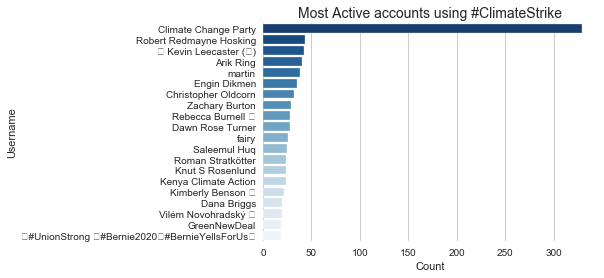

In [14]:
counts = tweets_df['User_name'].value_counts()
df_counts = pd.DataFrame()
df_counts['Username'] = counts.index
df_counts['Count'] = counts.values
df_counts = df_counts.iloc[:20,:]

fig, ax = plt.subplots(figsize = (6, 4))
g = sns.barplot(x = "Count", y = "Username", data = df_counts, palette = "Blues_r")
plt.title("Most Active accounts using #ClimateStrike", fontsize = 14)
plt.show()

The the 20 most active users are all individual accounts and not accounts of organizations or political parties.

#### 2.5 Verified Accounts

In order to begin our analysis on the twitter leaders, it is important to know the number of verified Twitter accounts in our dataset. Verified accounts on Twitter lets people know that these are accounts of public interest and through Twitter verification, they are deemed authentic. Typically these accounts are owned by users in music, acting, fashion, government, politics, religion, journalism, media, sports, business, and other key interest areas. In another words, accounts whose owners are famous and/or his/her opinions are influential.

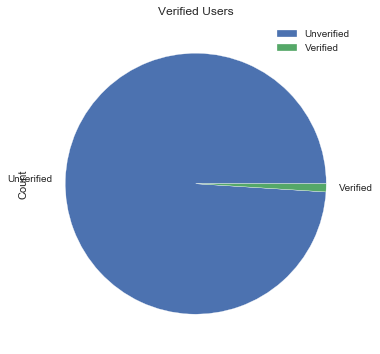

In [15]:
df_unique = pd.DataFrame([tweets_df['User_name'],tweets_df['Verified_user']]).T
df_unique = df_unique.loc[~df_unique.duplicated(keep = 'first')]
counts = df_unique['Verified_user'].value_counts()
df = pd.DataFrame([counts.values[0], counts.values[1]], index=['Unverified', 'Verified'], columns = ['Count'])
df.plot(kind='pie', subplots = True, figsize=(8, 6))
plt.title("Verified Users")
plt.show()

We can say that only a small proportion of Twitter users in the dataset are people of public interest and thus would have a greater spread of message through media.

#### 2.6 Identifying Twitter Leader 

By identifying the top Twitter users with the highest number of followers, we investigate their number of tweets using this hashtag, number of favourites and number of retweets they got during this period. Through this we can measure which Twitter user is the most influential, in the sense that the have the widest reach of audience and garners the most reactions from them.

In [16]:
df_tweet_count = tweets_df.loc[:,['User_name','User_follwers_count', 'Tweet_body', 'Favourite_count', 'Retweet_count']]
df_tweet_count = df_tweet_count.loc[~df_tweet_count.duplicated(keep = 'first')]
df_tweet_count.sort_values(by = 'User_follwers_count', ascending = False, inplace = True)
df_count = pd.DataFrame()
df_count = df_tweet_count.iloc[:19,:]
df_count = pd.pivot_table(df_count , values = ['User_follwers_count', 'Tweet_body', 'Favourite_count', 'Retweet_count'],
                         index=['User_name'], aggfunc={'User_follwers_count': max,
                              'Tweet_body': 'count',
                                'Favourite_count': np.sum,
                                'Retweet_count': np.sum})
df_count.sort_values(by = 'User_follwers_count', ascending = False, inplace = True)
df_count = df_count.reset_index()
df_count

User_name  Favourite_count  Retweet_count  Tweet_body  \
0              MTV NEWS              801            172           4   
1        Greta Thunberg             3430           2134           5   
2            Greenpeace                0            501           2   
3              UN Women              223             89           1   
4  Greenpeace Indonesia                0            466           1   
5       liam cunningham                0           4571           1   
6           Sierra Club               50           4701           5   

   User_follwers_count  
0              5140925  
1              3952300  
2              1874962  
3              1728164  
4               945180  
5               557731  
6               363548

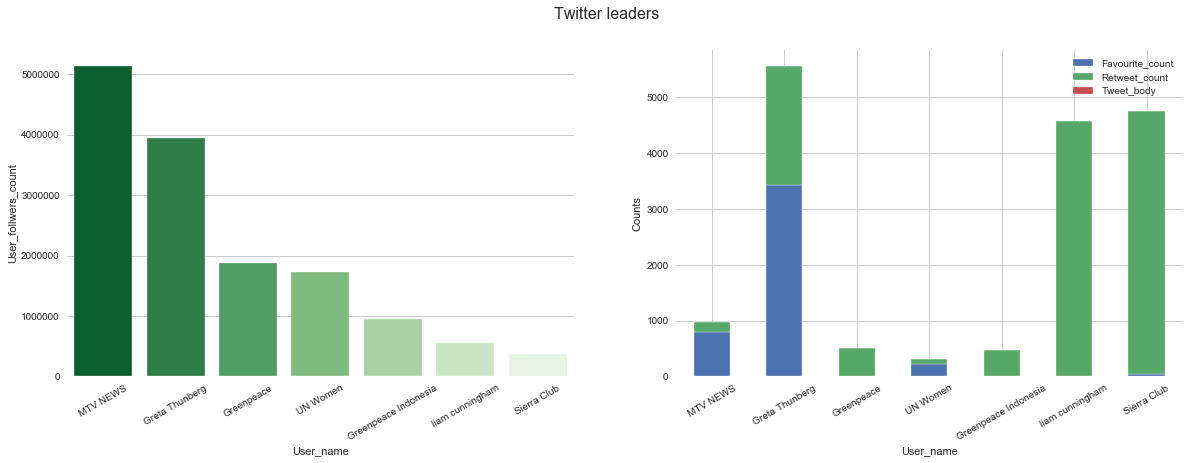

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (20,6))
plt.suptitle("Twitter leaders", fontsize = 16)
g = sns.barplot(x = "User_name", y = "User_follwers_count", data = df_count, palette = "Greens_r", ax = ax[0])
f = df_count.drop(["User_follwers_count"], axis = 1).plot(kind='bar', stacked = True, ax = ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
f.set_xticklabels(g.get_xticklabels(), rotation=30)
f.set(xlabel = 'User_name', ylabel = 'Counts')
plt.show()

The results confirm what we already know, especially for the ones with the most followers, they are news organizations (MTV News), charities (Greenpeace and Greenpeace Indoesia), political organizations (UN Women), activist (Greta Thunberg) and celebrities (Liam Cunningham). By aggregating their amount of tweets, favourites and retweets, we identy Greta Thunberg, the climate activist, as the most influential Twitter user in this hashtag during this period. 

#### 2.7 Twitter Users Locations

We investigate the Twitter users' locations through visualizing the frequency of tweets published from each indicated location on their user profiles. Since the locations are set by the users, there are a lot of different values of input for this specific data column. For simiplicity we clean only the top 100 places with the most tweets published. 

In [18]:
country_names = [country.name for country in pycountry.countries]
locations = []
unsorted = []
#Cleaning Country attribute
country_mapping = {'United States':['California, USA', 'united states of america', 'Massachusetts', 'new york',
                                    'ny', 'USA', 'Washington, DC', 'Los Angeles, CA', 'Haslett, MI', 'Miami, FL'
                                   , 'Seattle, WA', 'Bellingham, WA', 'New York', 'NY', 'Michigan, USA'],
                   "Chile": ["santiago"], 'Canada':["Comox Valley, BC", 'Toronto, Ontario', 'Ottawa, Ontario'],
                  'Germany': ['Deutschland',"Halle (Saale), Deutschland", 'Berlin'], "Israel": ["Tel Aviv"], 
                   "United Kingdom": ['London, England','TELFORD UK', "UK"], "Mexico":['México']}

for i in range(len(tweets_df["User_geolocation"])):
    if tweets_df["User_geolocation"][i] == "Unceded Squamish Territory":
        tweets_df["User_geolocation"][i] = None
    if tweets_df["User_geolocation"][i] != None:
        if tweets_df["User_geolocation"][i] in country_mapping.values():
            locations.append(keys_by_value(country_mapping, tweets_df["User_geolocation"][i]))
        else:
            for country in country_names:
                if country in tweets_df["User_geolocation"][i]:
                    locations.append(country)

In [19]:
locations_df = pd.DataFrame(locations)
locations_df = pd.DataFrame(locations_df[0].value_counts()).reset_index()
locations_df.columns = ["Country", "Counts"]
iso = [country_name_to_country_alpha3(i) for i in locations_df["Country"]]
locations_df["iso"] = iso
fig = px.scatter_geo(locations_df, locations = "iso", hover_name = "Country", size = "Counts",
                     projection = "natural earth")
fig.show()

Canada and Australia have the highest number of tweets with the hashtag **#ClimteStrike**. Based on the scatterplot on the map, we can say that the locations of these users are relatively spread out globally, with tweets from all 5 continents including Antarctica. 

Another interesting fact is if we compare the results in Europe to the EU election results where the green seats were won, they are fairly similar in location and in sizes of population.

<img src="guardian.png" width=400>
Source: Guardian news

## 3. Analysis on the content of the Tweets

#### 3.1 WordCloud
In this section we are going to visualize the most frequent words for each language. For simiplicity we are only using English tweets. We are going to use WordClound and the STOPWORDS list from the module to visualize our result.

In [20]:
eng_df = tweets_df[tweets_df['Tweet_language'] == 'en']

In [21]:
clean_text = Clean_Tweets()
eng_df['Tweet_body'] = clean_text.fit_transform(eng_df.Tweet_body)

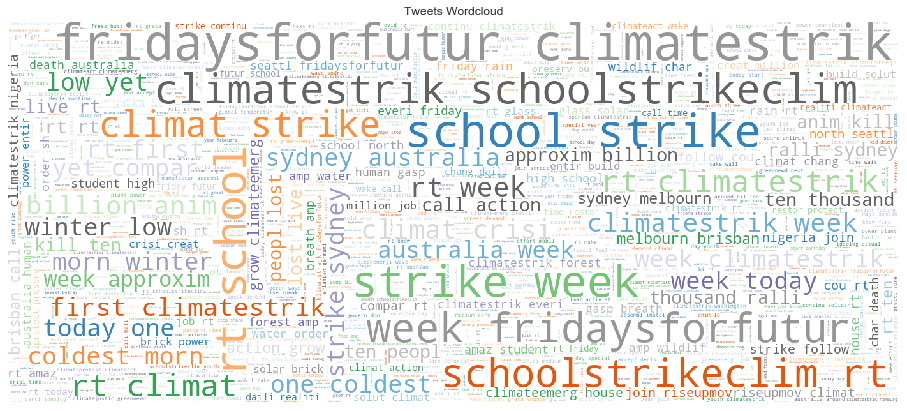

In [22]:
wc = WordCloud(height = 600,repeat = False, width = 1400, max_words = 1000,stopwords = STOPWORDS,
               colormap = 'tab20c',background_color='White',mode='RGBA').generate(' '.join(eng_df['Tweet_body'].dropna().astype(str)))
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.title('Tweets Wordcloud')
plt.axis('off')
plt.show()

According to the WordCloud above, we can see that most tweets mentioned  climate strike/school strike/joining the Fridays for Future movement. Some are addressing the climate phenomenon e.g. "billion [animals]", "people lost", "coldest morning", etc... Therefore we can infer that the tweets are mostly about informing the audience about the climate crisis as well as advertising about the said movements.

#### 3.2 Cosine Similarity
By measuring the consine similarities between tweets to each other we can obtain an idea of how similar in text they are. We are using “Term Frequency – Inverse Document” Frequency as they count the frequency of each word in a document but not across documents, and then take inverse of the document frequency weightings. This allow effective comparison of tweets to each other.

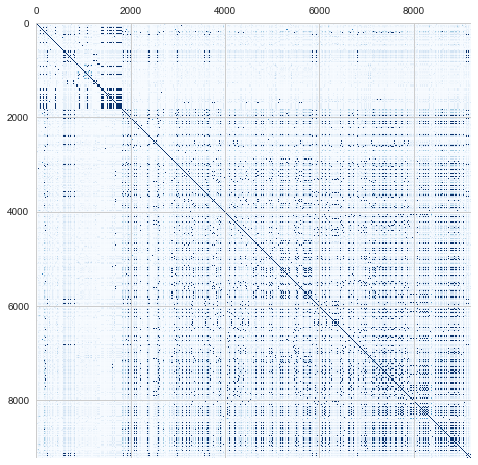

In [23]:
count_Tweets = TfidfVectorizer(binary = False, decode_error = 'ignore', stop_words = 'english')
tweets = count_Tweets.fit_transform(eng_df["Tweet_body"])
tweets = tweets.toarray()
index = cosine_similarity(tweets)
fig, ax = plt.subplots(figsize = (8, 8))
ax.matshow(index, cmap = 'Blues');

As we can see, the tweets are relatively similar to each other. This confirms that a significant of tweets each day consist of retweets.

#### 3.3 Tweets Text Modelling
Since the word vectors are of high-dimensional data therefore hard to visualize. We will use PCA and t-SNE to carry out dimensionality reduction. 

Firstly, we project the words data to a lower dimensional space through PCA and then visualize the first two dimensions. By using Word2Vec, we convert each word to a 100-dimension vector.

In [24]:
tokenised = [i.split() for i in eng_df['Tweet_body']]
model = Word2Vec(tokenised, min_count = 1)
words = list(model.wv.vocab)
print(model['watch'].shape)

(100,)


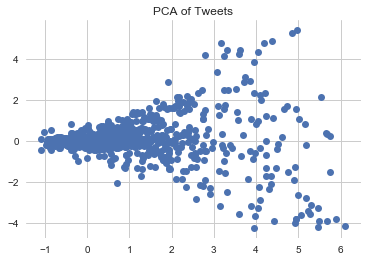

In [25]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('PCA of Tweets')
plt.show()

It is difficult to identify differences in the words in tweets groupings through PCA.

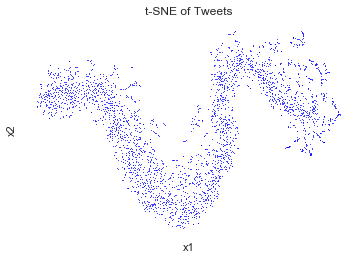

In [26]:
tsne = TSNE(n_components=2, init='pca', random_state=0)  
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, title = "t-SNE of Tweets")
plt.show()

Through t-SNE, we can see that words in these tweets generally belong to one large grouping.

## 4. Sentiment Analysis

#### 4.1 Word Frenquency and Sentiment Analysis
AFinn Lexicon is a dictionary based lexicon and we are using it to investigate the sentiment of these tweets.


In [27]:
body = []
retweets = []
for i in range(len(tweets_df["Tweet_body"])):
    words = remove_unwated(tweets_df["Tweet_body"][i]).lower()
    words = remove_stopwords(words)
    words = words.split()
    if tweets_df["Retweet"][i] == 1:
        for j in words:
            retweets.append(j)
    for j in words:
        body.append(j)
body = collections.Counter(body)
retweets = collections.Counter(retweets)

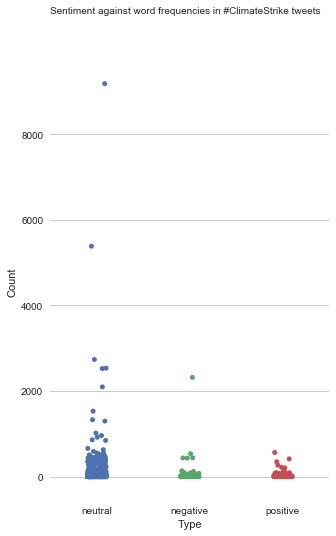

In [28]:
afinn = Afinn()
df_af = pd.DataFrame(body, index=[0]).T.reset_index()
df_af0 = pd.DataFrame(retweets, index=[0]).T.reset_index()
df_af = pd.merge(df_af, df_af0, on = 'index')
df_af.columns = ['Words', 'Count', 'Retweet_Count']
df_af['Scores'] = df_af.apply(lambda x: afinn.score(x["Words"]), axis=1)
df_af['Type'] = df_af['Scores'].apply(lambda x: 'negative' if x < 0 else 'positive' if x > 0 else 'neutral')

plt.figure(figsize = (5,8))
ax = sns.stripplot(x="Type", y="Count", data=df_af, jitter=True)
plt.suptitle("Sentiment against word frequencies in #ClimateStrike tweets", fontsize = 10)
plt.show()

According to the Afinn lexicon, most of the words in the tweets are neutral with higher frequencies than both negative and positive words. However please note that some of the words may have a score of 0 and thus categorized as neutral, but in fact they may be words that are not present in the Afinn lexicon dictionary of words.

#### 4.2 Most Positive and Negative Words

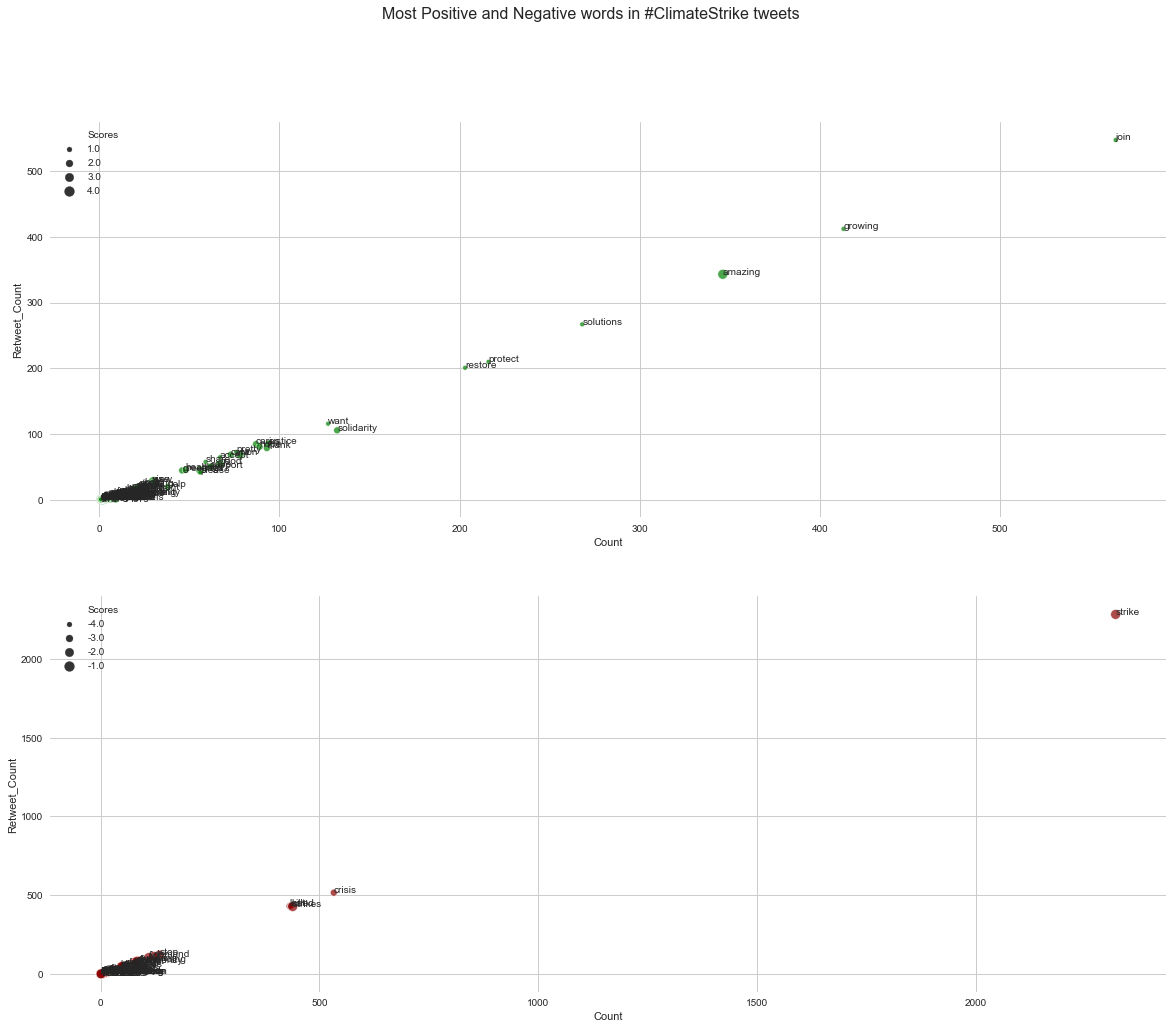

In [29]:
##top 10 positive and negative words
df_pos = df_af[df_af['Scores'] > 0]
df_neg = df_af[df_af['Scores'] < 0]
df_pos.sort_values(ascending = False, by = 'Scores', inplace = True)
df_neg.sort_values(ascending = True, by = 'Scores', inplace = True)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,16))
g = sns.scatterplot(x = 'Count', y = "Retweet_Count", data = df_pos, ax = ax[0], color = "green", alpha = 0.7, size = "Scores")
f = sns.scatterplot(x = 'Count', y = "Retweet_Count", data = df_neg,  ax = ax[1], color = "darkred", alpha = 0.7, size = "Scores")
plt.suptitle("Most Positive and Negative words in #ClimateStrike tweets", fontsize = 16)

label_point(df_pos.Count, df_pos.Retweet_Count, df_pos.Words, g)
label_point(df_neg.Count, df_neg.Retweet_Count, df_neg.Words, f)
plt.show()

Positive and negative word occurences are consistent in both total amount of tweets and total amount of retweets. Furthermore, we can say that there are more occurences of negative words than positive words. The word with the highest positive score 'amazing' has a frequency of around 350 in the total amount of tweets, yet for the most negative word 'crisis' it has an occurence count of around 510. According to the Afinn lexicon the word 'strike' is relatively negative and it is repeated a lot in the tweets since it is in the hashtag **#ClimateStrike** itself. We can say that the tweets containing the hashtag **#ClimateStrike** are relatively negative in sentiment.


## 5. Conclusion

As a result of our data analysis, we found out that tweets with the hashtag **#ClimateStrike** are influential in nature as amongst the 10,095 tweets we collected, there are significant proportions of reactions such as retweets and favourites daily. Twitter users who include this hashtag also includes other related hashtags such as **#StopAdahni** to inform their audiences about other climate change movements. Furthermore, although most of them are inidvidual account users, those who have a Verified Account status tend to have a greater influence with their tweets. With the top 7 users with the most followers being Verified accounts, they have the highest proportion of Reactions to Tweet ratio. By aggregating their amount of activities generated, we identify the climate activist Greta Thunberg as the opinion leader during this period. Regarding the locations of these users, Canada and Australia have the highest number of tweets with the hashtag #ClimteStrike. Based on the scatterplot on the map, we can say that the locations of these users are relatively spread out globally including all 5 continents. This shows that this topic has a global audience. Furthermore, if we compare our results in Europe to the green seats won in the 2019 EU election, they are errily similar in location and of sizes of population.

Through text analysis we found out that most tweets are similar words, with the most frequently used words being synonyms of the Climate Strike movement as well as names of other related activities. Moreover, words describing the effects of climate change are also frequently used. These words include 'lives lost' and 'billion animals'. They may be referring to the devastating situation happening during the Australian Bush Fire season.

We can conclude that the public's reaction towards this movement is staggering, with more than 10,000 tweets in a 6-day span. We used Afinn lexicon to conduct sentiment analysis in orer to capture the mood of the tweets as a whole. As a result we found that the tweets generally consists of neutral words, but there are significantly more negative sentiment than positive. It shows that speech on social media in the context of climate change activism are carrying more negativity.

Upon reflection, another characteristic of the Twitter user that I'm very much interested in is the age group demographics. It would be valuable to know the age population of people who pay attention to this movement. We know already it's primarily an youth movement, but how many of them are adults? Young adults and middle-aged? This may address even more in depth questions like how opinions of the youth affect the older generations. More importantly, how do the older generations react to the youth? It is a shame that due to Twitter's privacy policyies we are unable to obtain further details about the age groups that the users are in.

## 6. References

Plotly - https://plot.ly/python/scatter-plots-on-maps/ 

Word2Vec - https://rlbarter.github.io/superheat-examples/word2vec/

Afinn lexicon - https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.html